### Student Information
Name: 蘇昭融

Student ID: 112062506

GitHub ID: jhaorong

Kaggle name: kooe777

Kaggle private scoreboard snapshot:
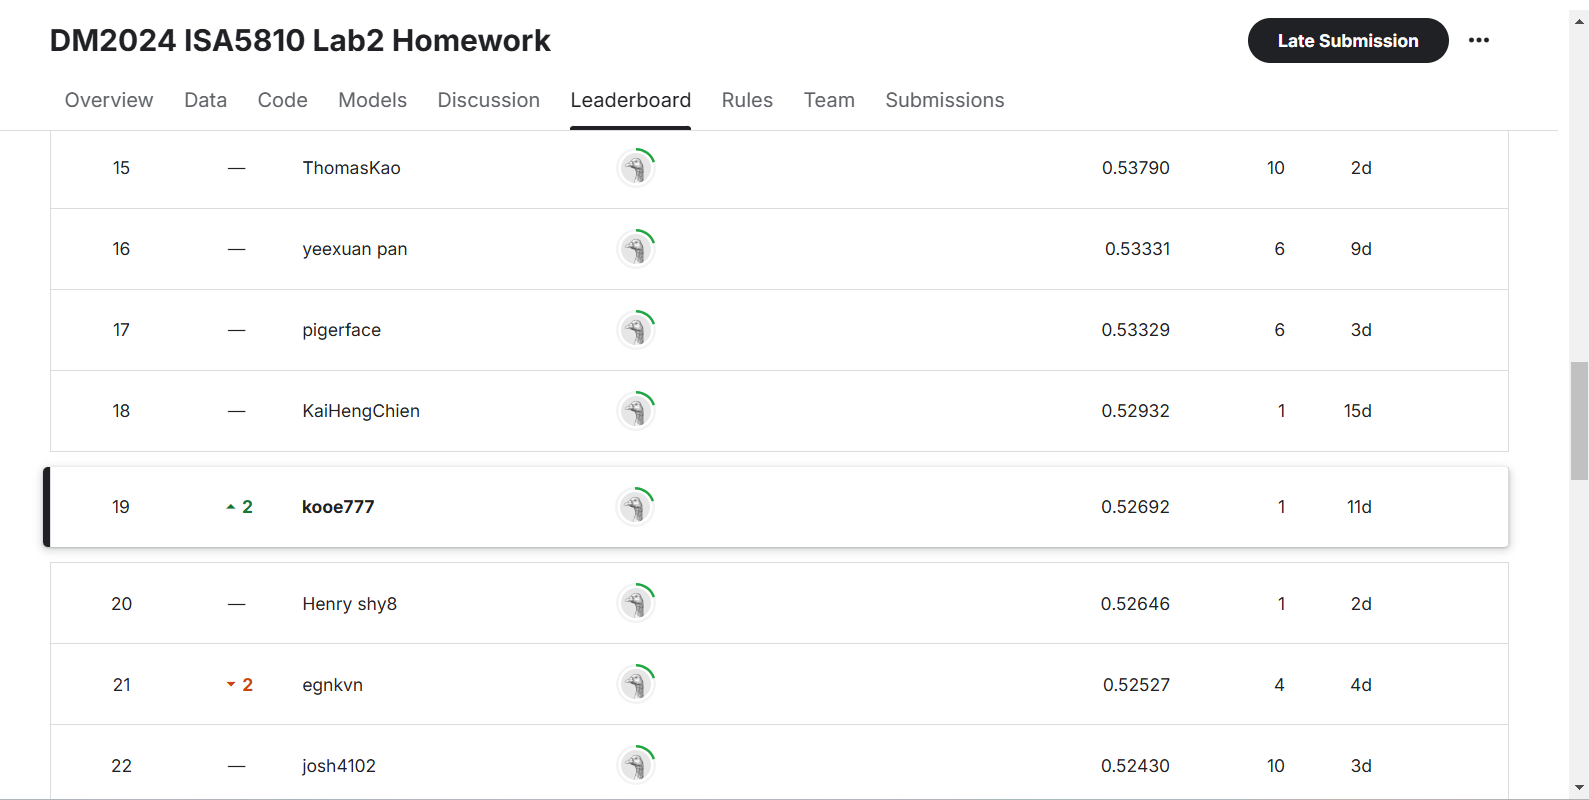

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__. 

## Second

### Data organizing

In [1]:
input_path = '/kaggle/input/dm-2024-isa-5810-lab-2-homework'

In [ ]:
# Read train and test identification data
import pandas as pd
data_ids = pd.read_csv(f'{input_path}/data_identification.csv')
print('data_identification')
print(data_ids.head())

# Split the data into training and testing sets.
train_data_ids = data_ids[data_ids['identification'] == 'train'].drop(['identification'], axis=1)
test_data_ids = data_ids[data_ids['identification'] == 'test'].drop(['identification'], axis=1)
print('train')
print(train_data_ids.head())

In [ ]:
# read 
emotion_labels = pd.read_csv(f'{input_path}/emotion.csv')
emotion_labels.head()

In [ ]:
tweets_df = pd.read_json(f'{input_path}/tweets_DM.json', lines=True)

print(tweets_df.head())

source_df = pd.json_normalize(tweets_df['_source'])

tweets_df = pd.concat([tweets_df.drop(columns=['_source']), source_df], axis=1)

print(tweets_df.head())

In [ ]:
train_data = pd.merge(train_data_ids, emotion_labels, on='tweet_id', how='inner')
train_data = pd.merge(train_data, tweets_df, left_on='tweet_id', right_on='tweet.tweet_id', how='inner')
train_data.head()

In [ ]:
test_data = pd.merge(test_data_ids, tweets_df, left_on='tweet_id', right_on='tweet.tweet_id', how='inner')
test_data.head()

In [ ]:
# drop useless column 
drop_columns = ['_score','_index','_crawldate','_type','tweet.hashtags','tweet.tweet_id']
train_data.drop(drop_columns,axis=1,inplace=True)
test_data.drop(drop_columns,axis=1,inplace=True)
# rename column name
train_data = train_data.rename(columns={"tweet.text": "text"})
test_data = test_data.rename(columns={"tweet.text": "text"})

In [ ]:
train_data.head()

In [ ]:
test_data.head()

### Data class distribution

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_category_distribution(df, category_column):
    # 計算每個類別的資料筆數
    category_counts = df[category_column].value_counts()

    # 繪製長條圖
    plt.figure(figsize=(10, 6))
    bars = plt.bar(category_counts.index, category_counts.values, color='skyblue', alpha=0.8)

    # 在每個長條上顯示資料筆數
    for bar, count in zip(bars, category_counts.values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2000,  # 調整文字位置
                 f'{count:,}', ha='center', va='bottom', fontsize=10)

    # 圖表標題和標籤
    plt.xlabel('Categories', fontsize=12)
    plt.ylabel('Number of Samples', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 顯示圖表
    plt.tight_layout()
    plt.show()

#### Original Data Distribution

In [ ]:
plot_category_distribution(train_data, 'emotion')

#### Oversampling

In [ ]:
from sklearn.utils import resample
import pandas as pd

def oversampling(dataframe, label_col):
    # 計算每個類別的樣本數
    class_counts = dataframe[label_col].value_counts()
    max_count = class_counts.max()
    print("原始類別分布：")
    print(class_counts)

    # 過採樣的數據保存
    upsampled_frames = []

    for cls in class_counts.index:
        # 過採樣每個類別
        class_data = dataframe[dataframe[label_col] == cls]
        if len(class_data) < max_count:
            upsampled_class = resample(class_data,
                                       replace=True,  # 允許重複取樣
                                       n_samples=max_count,  # 取樣至最大類別數量
                                       random_state=42)
            upsampled_frames.append(upsampled_class)
        else:
            upsampled_frames.append(class_data)

    # 合併所有過採樣後的類別數據
    balanced_data = pd.concat(upsampled_frames, axis=0).reset_index(drop=True)

    print("\n過採樣後類別分布：")
    print(balanced_data[label_col].value_counts())
    return balanced_data

train_data = oversampling(train_data, 'emotion')
plot_category_distribution(train_data, 'emotion')

#### Downsampling

In [ ]:
from sklearn.utils import resample
import pandas as pd

def downsampling(dataframe, label_col):
    """
    對所有類別進行下採樣，使所有類別的樣本數相等。
    :param dataframe: pd.DataFrame，包含數據和類別標籤
    :param label_col: str，類別欄位名稱
    :return: pd.DataFrame，下採樣後的數據集
    """
    # 計算每個類別的樣本數
    class_counts = dataframe[label_col].value_counts()
    print("原始類別分布：")
    print(class_counts)

    # 找到樣本最少的類別的樣本數
    min_samples = class_counts.min()
    print(f"\n下採樣目標樣本數：{min_samples}")

    # 保存下採樣後的數據
    downsampled_data = []

    for cls in class_counts.index:
        class_data = dataframe[dataframe[label_col] == cls]
        # 對每個類別進行下採樣
        sampled_data = resample(class_data,
                                replace=False,  # 不重複取樣
                                n_samples=min_samples,
                                random_state=42)
        downsampled_data.append(sampled_data)

    # 合併下採樣後的數據
    downsampled_df = pd.concat(downsampled_data).reset_index(drop=True)

    print("\n下採樣後的類別分布：")
    print(downsampled_df[label_col].value_counts())
    return downsampled_df

train_data = downsampling(train_data, 'emotion')
plot_category_distribution(train_data, 'emotion')

#### Mediansampling

In [ ]:
from sklearn.utils import resample
import pandas as pd
import numpy as np

def mediansampling(dataframe, label_col):
    """
    結合上採樣和下採樣的方法平衡多分類資料。
    :param dataframe: pd.DataFrame，包含數據和類別標籤
    :param label_col: str，類別欄位名稱
    :return: pd.DataFrame，平衡後的數據集
    """
    # 計算每個類別的樣本數
    class_counts = dataframe[label_col].value_counts()
    print("原始類別分布：")
    print(class_counts)

    # 計算樣本數目標範圍（例如使用中位數）
    target_size = int(np.median(class_counts))  # 取中位數作為目標樣本數
    print(f"\n目標樣本數（中位數）：{target_size}")

    # 保存平衡後的數據
    balanced_data = []

    for cls, count in class_counts.items():
        class_data = dataframe[dataframe[label_col] == cls]
        if count > target_size:
            # 對多數類別進行下採樣
            sampled_data = resample(class_data,
                                    replace=False,  # 不重複取樣
                                    n_samples=target_size,
                                    random_state=42)
        else:
            # 對少數類別進行上採樣
            sampled_data = resample(class_data,
                                    replace=True,  # 重複取樣
                                    n_samples=target_size,
                                    random_state=42)
        balanced_data.append(sampled_data)

    # 合併平衡後的數據
    balanced_df = pd.concat(balanced_data).reset_index(drop=True)

    print("\n平衡後的類別分布：")
    print(balanced_df[label_col].value_counts())
    return balanced_df

train_data = mediansampling(train_data, 'emotion')
plot_category_distribution(train_data, 'emotion')

### Data preprocessing

In [ ]:
# check whether there is null data
train_data["text"].isna().sum()

In [ ]:
# label encode the emotion data
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
train_data['labels'] = labelencoder.fit_transform(train_data['emotion'])

In [ ]:
# split data into train and evaluation data
from sklearn.model_selection import train_test_split


train_split, eval_split = train_test_split(train_data, test_size=0.2, random_state=42)
train_split = train_split.reset_index(drop=True)
eval_split = eval_split.reset_index(drop=True)

#### Tokenize text and handle text data

In [ ]:
!pip3 install nltk emoji==0.6.0

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from emoji import demojize
# tokenize method 1: nltk TweetTokenizer
## from nltk.tokenize import TweetTokenizer
## tokenizer = TweetTokenizer()

# tokenize method 2: bertweet default tokenizer
model_name = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token


def normalizeTweet(tweet):
    tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )

    return " ".join(normTweet.split())

#### Pack data into Dataset 

In [ ]:
from torch.utils.data import Dataset, DataLoader
class TweetDataset(Dataset):
    def __init__(self, tweets, labels=None):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        tweet = normalizeTweet(self.tweets[idx])
        encoding = tokenizer(tweet, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        if self.labels is not None:
            return {
                "input_ids": encoding["input_ids"].squeeze(),
                "attention_mask": encoding["attention_mask"].squeeze(),
                "labels": torch.tensor(self.labels[idx], dtype=torch.long),
            }
        else:
            return {
                "input_ids": encoding["input_ids"].squeeze(),
                "attention_mask": encoding["attention_mask"].squeeze(),
            }

train_dataset = TweetDataset(train_split['text'], train_split['labels'])
eval_dataset = TweetDataset(eval_split['text'], eval_split['labels'])

### Model

In [ ]:
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
model_name = "vinai/bertweet-base"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=8)

In [ ]:
# Train arguments setting
training_args = TrainingArguments(
    output_dir="./results",
    run_name="bert-finetuning",
    #eval_strategy="no",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to=[],
    fp16=True,
    #no_cuda=False,
)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
def compute_metrics(pred):
    labels = pred.label_ids  
    preds = np.argmax(pred.predictions, axis=1)  
    f1 = f1_score(labels, preds, average="weighted")  
    acc = accuracy_score(labels, preds)  
    return {"f1": f1, "accuracy": acc}

In [ ]:
# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [ ]:
metrics = trainer.evaluate()
print(metrics)  

In [ ]:
model.save_pretrained("./bertweet-finetuned")

### Inference

In [ ]:
test_dataset = TweetDataset(test_data['text'])
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from tqdm import tqdm

model.eval()

predictions = []
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Testing"):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())

test_data['emotion'] = labelencoder.inverse_transform(predictions)

submission = test_data[['tweet_id', 'emotion']]

submission = submission.rename(columns={'tweet_id': 'id'})

submission.to_csv("submission.csv", index=False)
submission.head()